<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#The-example-and-the-graph" data-toc-modified-id="The-example-and-the-graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The example and the graph</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#First-get-one-trajectory" data-toc-modified-id="First-get-one-trajectory-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>First get one trajectory</a></span></li><li><span><a href="#Get-a-bunch-of-trajectories-to-plot" data-toc-modified-id="Get-a-bunch-of-trajectories-to-plot-2.0.0.2"><span class="toc-item-num">2.0.0.2&nbsp;&nbsp;</span>Get a bunch of trajectories to plot</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

In [2]:
epsilon = 10e-80
vmin = -3.0
remove = 0.010
dt = 0.0001

In [3]:
lw = 8
ms = 20
alpha_graph = 0.3
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = (14, 10)
sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})

# The example and the graph

#### First get one trajectory

In [13]:
n_trajectories = 50
indexes = [0, 1, 2, 3]
sigma_out_trajectories = 0.05

In [14]:
%%time

strict_maximum = True

g_a = 1.0
g_I = 0.5
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 6
n_patterns = 6

# Training
ws = 1.0
wn =  0.2
wb = -20.0
alpha = 0.3

T_persistence = 0.200

# Manager properties
values_to_save = ['o', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

nn.g_beta = 0.0

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb ,alpha=alpha)

T_recall = T_persistence * len(indexes)
T_cue = tau_s
I_cue = 0
nr = manager.canonical_network_representation

# Get the deterministic trajectories
manager.set_persistent_time_with_adaptation_gain(T_persistence)
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=0, empty_history=True, reset=True)
determnistic_trajectories = {}
for index in indexes:
    determnistic_trajectories[index] = manager.history['s'][:, index]
    
# Get the noisy trajectories
manager.nn.sigma_in = sigma_out_trajectories * np.sqrt(2 / tau_s)
trajectories_dic = {index:[] for index in indexes}

for _ in range(n_trajectories):
    manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=0, empty_history=True, reset=True)
    for index in indexes:
        trajectories_dic[index].append(np.copy(manager.history['s'][:, index]))

CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 13.7 s


#### Get a bunch of trajectories to plot

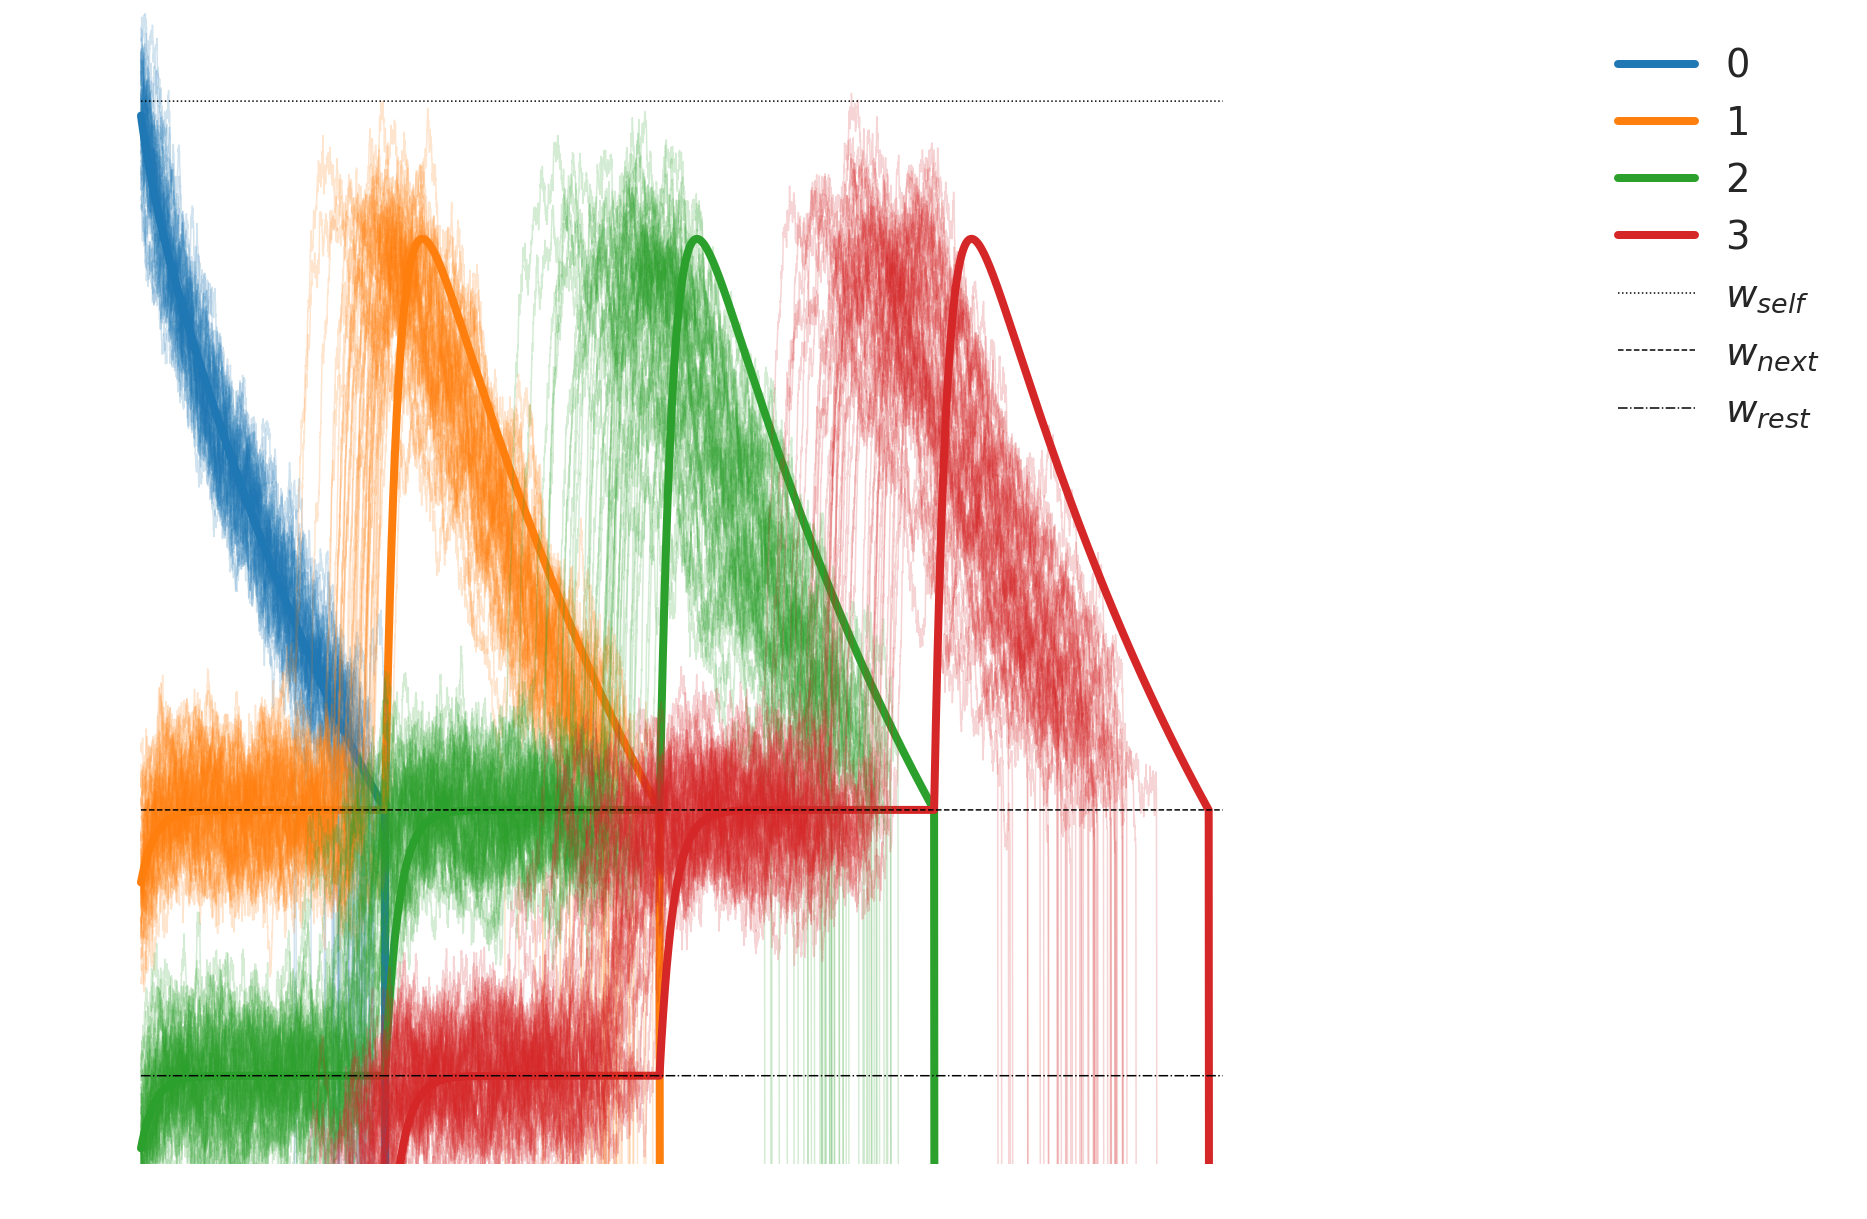

In [19]:
lw = 8
alpha_graph = 0.2
save = True
start = 2.25 * tau_s
star_index = int(start / dt)
plot_time = manager.time[star_index:]

factor_scale = 1.5
s1 = int(18 * factor_scale)
s2 = int(12 * factor_scale)

fig = plt.figure(figsize=(s1, s2))
ax = fig.add_subplot(111)

# Plot the deterministic trajectories
for index in indexes:
    s = determnistic_trajectories[index][star_index:]
    ax.plot(plot_time, s, lw=lw, color=colors[index], label=str(index))

# Plot the noise trajectories
for index in indexes:
    s_noise = trajectories_dic[index]
    for n_index in range(n_trajectories):
        s_instance = s_noise[n_index][star_index:]
        ax.plot(plot_time, s_instance, alpha=alpha_graph, color=colors[index])

# Plot the connectivity landmarks
if True:
    wr = wn - alpha
    ax.plot(plot_time, ws * np.ones(plot_time.size), ls=':', color='black', label=r'$w_{self}$')
    ax.plot(plot_time, wn * np.ones(plot_time.size), ls='--', color='black', label=r'$w_{next}$');
    ax.plot(plot_time, wr * np.ones(plot_time.size), ls='-.', color='black', label=r'$w_{rest}$')


ax.set_ylim([wr - 0.1, ws + 0.1])
ax.set_xlim([0, manager.time[-1] + 2.3 * T_persistence])
ax.legend(frameon=False, loc=1)

if True:
    ax.axis('off')

fig.tight_layout()
    
if save:
    directory = '../plot_producers/'
    file_name = 'noisy_trajectories_example' +str(n_trajectories) 
    format_string = '.pdf'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

In [7]:
manager.nn.w[:, 0]

array([ 1. ,  0.2, -0.1, -0.4, -0.7, -1. ])

In [8]:
x = np.array(trajectories_dic[1])

In [9]:
std_set = []
for i in range(1000):
    std_set.append(x[:, i].std())

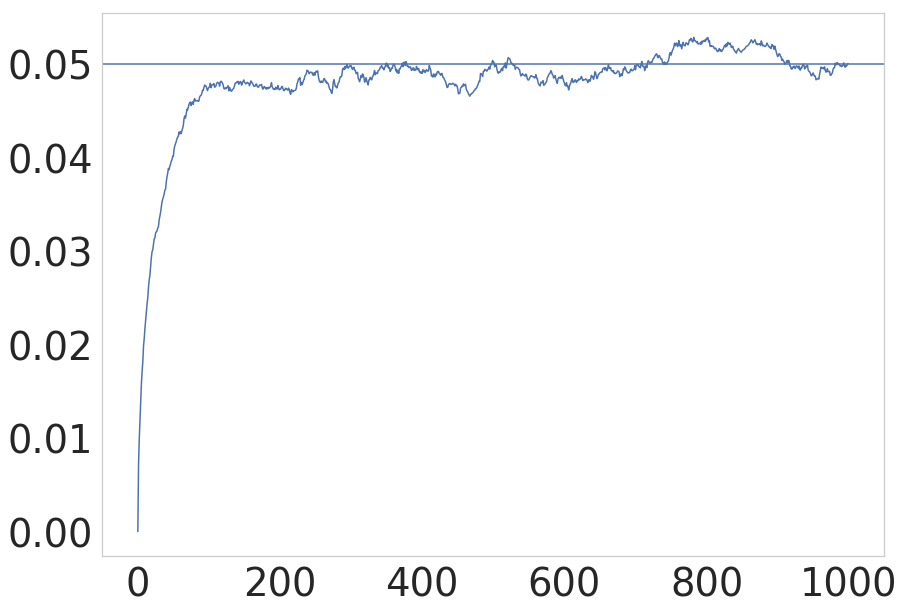

In [109]:
plt.plot(std_set)
plt.axhline(sigma_out_trajectories)